<a href="https://colab.research.google.com/github/profsuccodifrutta/patch_core_brain_mri/blob/main/patch_core_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/brainmri.zip'
extract_path = '/content/brain_dataset' # Cartella locale di Colab

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Estrazione completata!")

✅ Estrazione completata!


In [3]:
!pip install anomalib
!pip install faiss-cpu
!pip freeze > requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 60.5 MB/s eta 0:00:00
  Created wheel for freia: filename=FrEIA-0.2-py3-none-any.whl size=42763 sha256=d5926d3b9af4491bbc74b506d539bd91932458c7a822ebd244852c67944034c9
  Stored in d

In [4]:
import torch
from pathlib import Path
from anomalib.data import Folder
from anomalib.models import Patchcore
from anomalib.engine import Engine


DATA_PATH = Path('/content/brain_dataset')

datamodule = Folder(
    name="brain_mri",
    root=DATA_PATH,
    normal_dir="Training/notumor",      # Sani per il training
    normal_test_dir="Testing/notumor",  # Sani per il test
    abnormal_dir="Testing",             # Tutte le altre cartelle in Testing sono anomalie
    train_batch_size=8,
    eval_batch_size=8,
    num_workers=2
)
datamodule.setup()

print("✅ Configurazione completata. Pronto per l'estrazione delle feature.")

✅ Configurazione completata. Pronto per l'estrazione delle feature.


In [5]:
# PatchCore
model = Patchcore(
    backbone="resnet18",    #"wide_resnet50_2"
    layers=["layer2", "layer3"],
    coreset_sampling_ratio=0.01
)


engine = Engine(
    max_epochs=1,
    devices=1,
    accelerator="auto",
    enable_progress_bar=False
)

# Crea la memoria dei sani (Training)
print(" Avvio estrazione feature e creazione Memory Bank...")

engine.fit(model=model, datamodule=datamodule)

print(" Memory Bank creata con successo!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores


 Avvio estrazione feature e creazione Memory Bank...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor   │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor  │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator      │      0 │ train │     0 │
│ 3 │ model          │ PatchcoreModel │  2.8 M │ train │     0 │
└───┴────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 69                                                                                           
Total FLOPs: 0

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 69 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
Selecting Coreset Indices.: 100%|██████████| 16332/16332 [07:50<00:00, 34.75it/s]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


 Memory Bank creata con successo!


In [6]:
#  Confronta i malati con la memoria (Inference)
print(" Valutazione sulle anomalie...")
results = engine.test(model=model, datamodule=datamodule)

print("\n--- RISULTATI FINALI ---")
print(results)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


 Valutazione sulle anomalie...


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8428038358688354     │
│       image_F1Score       │    0.8638184070587158     │
└───────────────────────────┴───────────────────────────┘


--- RISULTATI FINALI ---
[{'image_AUROC': 0.8428038358688354, 'image_F1Score': 0.8638184070587158}]


In [8]:
# salva il modello
path_salvataggio = "/content/drive/MyDrive/patchcore_modelresnet18.ckpt"
engine.trainer.save_checkpoint(path_salvataggio)
print(f"✅ Modello salvato correttamente in: {path_salvataggio}")

INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.


✅ Modello salvato correttamente in: /content/drive/MyDrive/patchcore_modelresnet18.ckpt


In [10]:
# inferenza senza dover ricreare la memory bank
# Inizializzi il modello
model = Patchcore(backbone="resnet18", layers=["layer2", "layer3"])

# Carica pesi e la Memory Bank dal file
model = Patchcore.load_from_checkpoint(checkpoint_path="/content/drive/MyDrive/patchcore_modelresnet18.ckpt")

# Inizializzi l'Engine solo per il test/predict
engine = Engine(devices=1)

# 4. Fai inferenza su una nuova cartella di immagini
# (Oppure su una singola immagine usando engine.predict)
predictions = engine.predict(model=model, datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

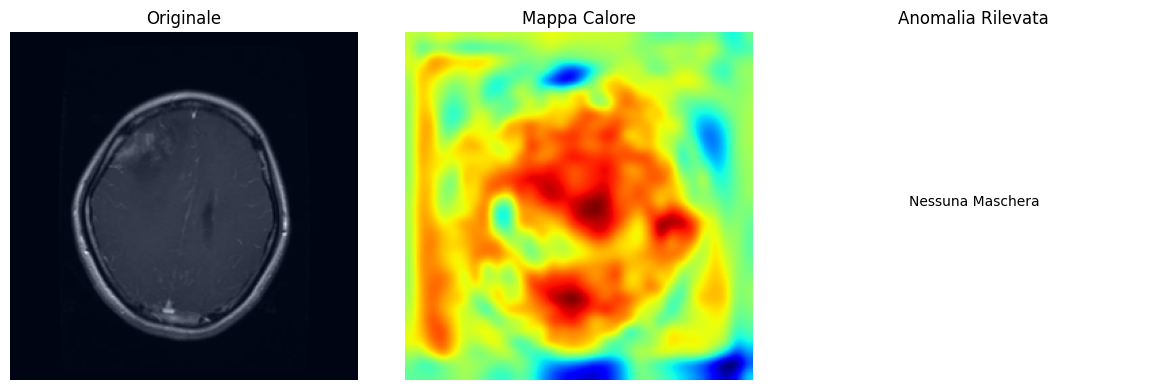

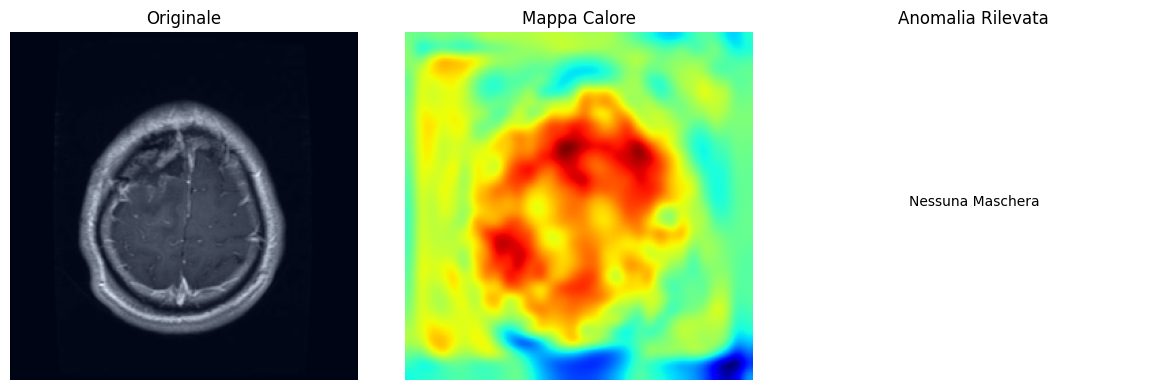

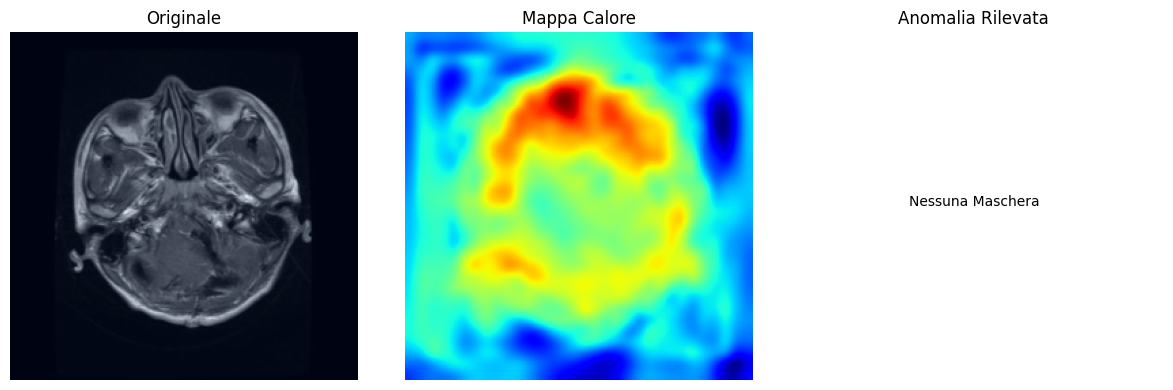

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

predictions = engine.predict(model=model, datamodule=datamodule)

for i, batch_result in enumerate(predictions):
    if i > 2: break

    plt.figure(figsize=(12, 4))

    img_tensor = batch_result["image"] if isinstance(batch_result, dict) else batch_result.image

    if isinstance(img_tensor, torch.Tensor) and img_tensor.ndim == 4:
        img_tensor = img_tensor[0]

    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Originale")
    plt.axis('off')

    amap_tensor = batch_result["anomaly_map"] if isinstance(batch_result, dict) else batch_result.anomaly_map

    if isinstance(amap_tensor, torch.Tensor):
        if amap_tensor.ndim == 4:
            amap_tensor = amap_tensor[0]
        if amap_tensor.ndim == 3:
            amap_tensor = amap_tensor[0]

        amap = amap_tensor.cpu().numpy()
        if amap.ndim == 3:
             amap = amap.squeeze()

    plt.subplot(1, 3, 2)
    plt.imshow(amap, cmap='jet')
    plt.title("Mappa Calore")
    plt.axis('off')

    mask_key = "pred_mask" if "pred_mask" in batch_result else "segmentations"
    mask_tensor = batch_result.get(mask_key) if isinstance(batch_result, dict) else getattr(batch_result, mask_key, None)

    plt.subplot(1, 3, 3)
    if mask_tensor is not None:
        if isinstance(mask_tensor, torch.Tensor):
            if mask_tensor.ndim == 4: mask_tensor = mask_tensor[0]
            mask = mask_tensor.cpu().numpy().squeeze()
        plt.imshow(mask, cmap='gray')
        plt.title("Anomalia (Mask)")
    else:
        plt.text(0.5, 0.5, "Nessuna Maschera", ha='center')
        plt.title("Anomalia Rilevata")
    plt.axis('off')

    plt.tight_layout()
    plt.show()